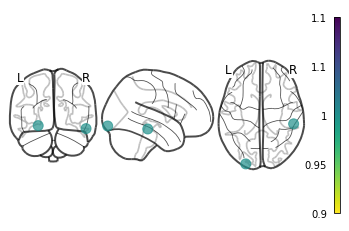

In [2]:
import sys

sys.path.append('../../src')

from imagenomer import Analysis, JsonData, JsonSubjects, JsonFCMetadata, JsonImage

analysis = Analysis(f'blah: blah', 'localhost')
json = JsonImage(analysis, {'regions': [0, 10]}).dict['b64']

In [1]:
import pickle

fname = '../../data/fmri-FC-slim.pkl'
fmriDict = None

with open(fname, 'rb') as f:
    fmriDict = pickle.load(f)
    
print(fmriDict.keys())

dict_keys(['FC-slim', 'subjNum2IdxMap', 'subjIdx2NumMap', 'groupsNormalDiagMap'])


In [2]:
def getGroupIdcs(groupsMap):
    normals = []
    fibros = []
    for num,diag in groupsMap.items():
        if diag == 1:
            normals.append(num)
        else:
            fibros.append(num)
    return normals,fibros

normals, fibros = getGroupIdcs(fmriDict['groupsNormalDiagMap'])

print(len(normals))
print(normals)
print(len(fibros))
print(fibros)

33
['007', '012', '014', '016', '018', '021', '022', '026', '030', '031', '032', '033', '034', '036', '042', '045', '047', '056', '058', '059', '060', '061', '064', '066', '068', '069', '070', '072', '073', '074', '075', '076', '077']
33
['002', '004', '005', '006', '008', '009', '010', '011', '013', '015', '017', '019', '020', '023', '024', '025', '028', '029', '037', '038', '039', '040', '043', '044', '046', '049', '050', '052', '053', '054', '055', '062', '063']


In [3]:
# Get response variables

def numInt2Str(num):
    num = int(num)
    return f'00{num}' if num < 10 else f'0{num}'

response = None

with open('../../data/fmri-clinical.pkl', 'rb') as f:
    response = pickle.load(f)
    
print(numInt2Str(response[0,4]))

007


In [4]:
import numpy as np

def getVar(num, normals, fibros, response, varIdx):
    num = numInt2Str(num)
    if num in normals or num in fibros:
        idx = np.where(int(num) == response[0])
        return float(response[varIdx,idx])
    raise Exception('num not in normal or fibros')

print([getVar(num, normals, fibros, response, 2) for num in normals])
print([getVar(num, normals, fibros, response, 2) for num in fibros])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 17.0, 0.67, 2.0, 7.0, 4.0, 2.0, 7.0, 6.0, 4.0, 0.16, 2.0, 6.0, 2.0, 0.4, 2.0, 15.0, 1.0, 0.5, 8.0, 6.0, 1.0, 0.66, 0.5, 0.33, 2.5, 4.0, 1.5, 9.0, 2.0, 20.0, 0.12, 7.0]


In [5]:
nRuns = 20
C = 0.001
model = f'Logistic Regression L2 C={C}'
desc = 'normal(1) vs. fibromyalgia(0) rest fMRI only, (W*FC)_1-(W*FC)_2'

import random
import numpy as np

from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn

import sys

sys.path.append('../../src')

from imagenomer import Analysis, JsonData, JsonSubjects, JsonFCMetadata

analysis = Analysis(f'{desc}: {model}', 'localhost')

a,b = np.triu_indices(264,1)
idcs = np.arange(34716)

labels = [f'{a[i]}-{b[i]}' for i in idcs]

print(labels[0:10])
print(labels[-10:])

mseLoss = nn.MSELoss()

for run in range(nRuns):
    FCslim = fmriDict['FC-slim']
    subjNum2Idx = fmriDict['subjNum2IdxMap']

    random.shuffle(normals)
    random.shuffle(fibros)

    normalTrain = normals[:25]
    normalTest = normals[25:]

    fibrosTrain = fibros[:25]
    fibrosTest = fibros[25:]

    train = normalTrain + fibrosTrain
    test = normalTest + fibrosTest

    Xtrain = [FCslim[subjNum2Idx[num]] for num in train]
    Xtest = [FCslim[subjNum2Idx[num]] for num in test]

    Xtrain = np.stack(Xtrain)
    Xtest = np.stack(Xtest)
    
#     Xtrain = torch.from_numpy(Xtrain)
#     Xtest = torch.from_numpy(Xtest)
    
#     ytrain = np.array([getVar(num, normals, fibros, response, 3) for num in train])
#     ytest = np.array([getVar(num, normals, fibros, response, 3) for num in test])
    
#     ytrain = torch.from_numpy(ytrain)
#     ytest = torch.from_numpy(ytest)
    
#     print(ytrain)
#     print(ytest)

    ytrain = np.concatenate([np.ones(25), np.zeros(25)])
    ytest = np.concatenate([np.ones(8), np.zeros(8)])

#     print(Xtrain.shape)
#     print(Xtest.shape)
#     print(ytrain.shape)
#     print(ytest.shape)

    clf = LogisticRegression(max_iter=5000, C=C).fit(Xtrain, ytrain)
#     clf = LogisticRegression(max_iter=5000, C=0.001, 
#                              solver='saga', penalty='l1').fit(Xtrain, ytrain)
    yhat = clf.predict(Xtest)
    acc = sum(yhat == ytest)/len(ytest)

#     w, _, _, _ = torch.linalg.lstsq(Xtrain, ytrain)
#     print((Xtest@w).shape)
#     acc = mseLoss(Xtest@w, ytest)**0.5
#     null = mseLoss(torch.mean(ytrain), ytest)**0.5
    
    print(f'{run}. {acc}')
    
    w = clf.coef_.squeeze()
    wHC = np.mean(np.expand_dims(w,0)*Xtest[:8], axis=0)
    wFM = np.mean(np.expand_dims(w,0)*Xtest[8:], axis=0)
    w = wHC-wFM
    
    jsonCompare = desc
    jsonAccuracy = acc
    jsonTrain = [25,25]
    jsonTest = [8,8]
    jsonWeights = w
    jsonLabels = labels

    jsonObj = {
        'Compare': jsonCompare,
        'Model': 'Logistic Regression',
        'Accuracy': jsonAccuracy,
        'Train': jsonTrain,
        'Test': jsonTest,
        'Weights': list(jsonWeights),
        'Labels': jsonLabels
    }
    
    dat = JsonData(analysis)
    dat.dict.update(jsonObj)
    r = dat.post()
    print(r.content)

['0-1', '0-2', '0-3', '0-4', '0-5', '0-6', '0-7', '0-8', '0-9', '0-10']
['259-260', '259-261', '259-262', '259-263', '260-261', '260-262', '260-263', '261-262', '261-263', '262-263']
0. 0.6875
b'Success'
1. 0.8125
b'Success'
2. 0.625
b'Success'
3. 0.75
b'Success'
4. 0.75
b'Success'
5. 0.75
b'Success'
6. 0.5625
b'Success'
7. 0.75
b'Success'
8. 0.375
b'Success'
9. 0.625
b'Success'
10. 0.625
b'Success'
11. 0.625
b'Success'
12. 0.6875
b'Success'
13. 0.6875
b'Success'
14. 0.625
b'Success'
15. 0.625
b'Success'
16. 0.5
b'Success'
17. 0.625
b'Success'
18. 0.6875
b'Success'
19. 0.5625
b'Success'


In [6]:
commNames = []
commAffil = {}
commAbrev = 'SMH,SMM,CNG,AUD,DMN,MEM,VIS,FRT,SAL,SUB,VTR,DRL,CB,UNK'.split(',')
commCount = np.zeros(14)

powerAffilFname = '../../power/power264CommunityAffiliation.1D'

with open(powerAffilFname, 'r') as f:
    for i,line in enumerate(f.readlines()):
        commAffil[i] = int(line)-1
        commCount[commAffil[i]] += 1
        
print(commAffil)
print(commCount.astype('int'))

{0: 13, 1: 13, 2: 13, 3: 13, 4: 13, 5: 13, 6: 13, 7: 13, 8: 13, 9: 13, 10: 13, 11: 13, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 2, 47: 2, 48: 2, 49: 2, 50: 2, 51: 2, 52: 2, 53: 2, 54: 2, 55: 2, 56: 2, 57: 2, 58: 2, 59: 2, 60: 3, 61: 3, 62: 3, 63: 3, 64: 3, 65: 3, 66: 3, 67: 3, 68: 3, 69: 3, 70: 3, 71: 3, 72: 3, 73: 4, 74: 4, 75: 4, 76: 4, 77: 4, 78: 4, 79: 4, 80: 4, 81: 4, 82: 4, 83: 13, 84: 13, 85: 4, 86: 4, 87: 4, 88: 4, 89: 4, 90: 4, 91: 4, 92: 4, 93: 4, 94: 4, 95: 4, 96: 4, 97: 4, 98: 4, 99: 4, 100: 4, 101: 4, 102: 4, 103: 4, 104: 4, 105: 4, 106: 4, 107: 4, 108: 4, 109: 4, 110: 4, 111: 4, 112: 4, 113: 4, 114: 4, 115: 4, 116: 4, 117: 4, 118: 4, 119: 4, 120: 4, 121: 4, 122: 4, 123: 4, 124: 4, 125: 4, 126: 4, 127: 4, 128: 4, 129: 4, 130: 4, 131: 13, 132: 5, 133: 5, 134: 5, 135: 5, 136: 4

In [7]:
jsonMeta = JsonFCMetadata(analysis)
metaDict = {
    'CommunityMap': commAffil,
    'CommunityNames': commAbrev
}
jsonMeta.update(metaDict)
r = jsonMeta.post()
print(r.content)

b'Success'
